<h1>Forecast Project</h1>

<h2>Database</h2>

<b>Import packages for DB</b>

In [1]:
import yfinance as yfin
import sqlite3 as sql
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np

<h3>YFianance API</h3>
<p>Function using the yfinance API to get all market data</p>

<b>Tickers</b>

In [2]:
#array with all the studied currencies (yahoo finance currency names)
currencies = ["BTC-USD","ETH-USD","TTE.PA"] 

In [3]:
def getMetaData(s : str) -> dict :
    """Get the meta information for a Ticker (currency)
    
    Args : 
        s (str) : name of the Ticker
        
    Return : 
        dict : return all the  meta information of the Ticker, the dict is the following : 
                - symbol : str ~> name online (yahoo finance) of the stock (is also the ticker name used by the yfinance API)
                - instrumentType : str ~> type of stock, can be a cryptocurrency ,  a stock ...
                - regularMarketTime int : ~> date when those informatation has been gathered in epoch/unix time 
                - gmtoffset int : ~> number of second of offset between the stock's market timezome and the gtm timzome
                - timezone str : ~> name of the stock's market timezone
            other var a disponnible but not used here (see yfinance documentation)
    """    
    ticker = yfin.Ticker(s)
    ticker.history()
    meta = ticker.history_metadata
    return meta
 
def getHistoryData(s : str) -> dict :
    """Get all the information since the creation of the Ticker (currency)
    
    Args : 
        s (str) : name of the Ticker
        
    Return : 
        dict : return all the  information of the Ticker since creation, the dict contaign the following information : {Date,Open,Hight,Low,Close,Volume}
    """
    ticker = yfin.Ticker(s)
    data = ticker.history("max", interval = '1d')
    data['Date'] = data.index
    data = data[["Date", "Open", "High", "Low", "Close", "Volume"]]
    data.reset_index(drop=True, inplace=True)
    return data

def getPeriodData(s : str , period : str) -> dict :
    """Get the information of the Ticker for a certain period
    
    Args : 
        s (str) : name of the Ticker
        period (str) : duration of the period , the information period get are ending to the current day and start a period back can take value like {1d , 5d , 1m , 1y , ...}
    
    Return : 
        dict : return all the  information of the Ticker for the period, the dict contaign the following information : {Date,Open,Hight,Low,Close,Volume}
    """
    ticker = yfin.Ticker(s)
    data = ticker.history(period = period ,interval = '1d')
    data['Date'] = data.index
    data = data[["Date", "Open", "High","Low", "Close", "Volume"]]
    data.reset_index(drop=True, inplace=True)
    return data

<h3>DataBase Gestion</h3>

<h4>Currencies_Metadata table</h4>
<p>This table contaign all the usefull metadata of each currencies fetched. It contaigns : </p>
<ul><li><b>currencyName</b> ~> name online (yahoo finance) of the stock (is also the ticker name used by the yfinance API)</li>
<li><b>instrumentType</b> ~> type of stock, can be a cryptocurrency ,  a stock ...</li>
<li><b>regularMarketTime</b> ~> date when those informatation has been gathered in epoch/unix time </li>
<li><b>gtmOffset</b> ~> number of second of offset between the stock's market timezome and the gtm timezome</li>
<li><b>timezone</b> ~> name of the stock's market timezone</li></ul>
It is possible to 
<ul><li>Create / Fill <b>table</b></li>
<li>Insert / Get / Modify / Delete / Print <b>table elements</b></li></ul>

In [38]:
def createCurrencyMetadataTable():
    """Create a new currency table """
    db = sql.connect("mydatabase.db")
    c = db.cursor()

    requestCreate = '''CREATE TABLE IF NOT EXISTS CURRENCIES_METADATA (
        [currencyId] INTEGER PRIMARY KEY AUTOINCREMENT,
        [currencyName] TEXT, 
        [instrumentType] TEXT,
        [regularMarketTime] INTEGER,
        [gtmOffset] INTEGER,
        [timezone] TEXT
        )'''
    #currencyName : str ~> name online (yahoo finance) of the stock (is also the ticker name used by the yfinance API)
    #instrumentType : str ~> type of stock, can be a cryptocurrency ,  a stock ...
    #regularMarketTime int : ~> date when those informatation has been gathered in epoch/unix time 
    #gtmOffset int : ~> number of second of offset between the stock's market timezome and the gtm timzome
    #timezone str : ~> name of the stock's market timezone
    c.execute(requestCreate) # create a new currency table
    db.commit()

def getCurrencyMetadataElement(currencyId : int) -> dict :
    """Get an element of the currency table by its id

    Args:
        currencyId (int): id of the currency in the table

    Returns:
        dict: return the element as a dict with all metadata of a currency
    """
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    request = f'''SELECT * FROM CURRENCIES_METADATA WHERE currencyId='{currencyId}' '''
    c.execute(request)
    return list(c.fetchone())

def getIdByNameCurrencyMetadata(currencyName: str) -> int :
    """Get an element id of the currency table by its name

    Args:
        currencyName (str): name of the stock

    Returns:
        int: return the element id
    """
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    request = f'''SELECT currencyId FROM CURRENCIES_METADATA WHERE currencyName='{currencyName}' '''
    c.execute(request)
    return c.fetchone()[0]

def printCurrencyMetadataElement(currencyId : int):
    """Print an element of the currency table by its id 

    Args:
        currencyId (int): id of the currency in the table 
    """
    metaData = getCurrencyMetadataElement(currencyId)
    header = f"-------- MetaData for {metaData[1]} --------"
    nHeader = len(header)
    print(header)
    print(f"\nName : {metaData[1]}")
    print(f"ID : {metaData[0]}")
    print(f"instrumentType : {metaData[2]}")
    print(f"regularMarketTime : {metaData[3]}")
    print(f"gtmOffset : {metaData[4]}")
    print(f"timezone : {metaData[5]}")
    footer = "\n"
    for i in range(nHeader): footer += "-"
    print(footer)

def insertCurrencyMetadataElement(currency : str):
    """Insert a new  element in the currency table

    Args:
        currency (str): name of the currency to fetch its metadata with the yFinance API
    """
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    metaData = getMetaData(currency)
    request = f'''INSERT INTO CURRENCIES_METADATA (currencyName,instrumenttype,regularMarketTime,gtmOffset,timezone)
        VALUES (
        '{metaData['symbol']}',
        '{metaData['instrumentType']}',
        {metaData['regularMarketTime']},
        {metaData['gmtoffset']},
        '{metaData['timezone']}')'''
    c.execute(request)
    db.commit()

def modifyCurrencyMetadataElement(currencyId : int, newMetaData : dict):
    """Modify an element in the currency table, the element to modify must be enteriely rewrite 

    Args:
        currencyId (int): id of the currency to modify in the currency table
        newMetaData (dict): dictionnary contaigning all the information of the currency even the ones not changed
    """
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    #All the information MUST be given in the newMetaData dict even the id and the ones not changed
    request = f'''UPDATE CURRENCIES_METADATA 
        SET 
        currencyId={newMetaData['currencyId']},
        currencyName='{newMetaData['symbol']}', 
        instrumentType='{newMetaData['instrumentType']}', 
        regularMarketTime={newMetaData['regularMarketTime']},
        gtmOffset={newMetaData['gtmOffset']},
        timezone='{newMetaData['timezone']}' 
        WHERE currencyId = {currencyId}'''
    c.execute(request)
    db.commit()

def deleteCurrencyMetadataElement(currencyId : int):
    """Delete an element from the currency table

    Args:
        currencyId (int): id of the currency to delete from the currency table
    """
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    request = f'''DELETE FROM CURRENCIES_METADATA
        WHERE currencyId = {currencyId}'''
    c.execute(request)
    db.commit()


<h4>Others</h4>
<p>Usefull an necessary function for next parts </p>

In [5]:
def cleanNameForSQL(s : str) -> str:
	"""Return a new string that dont contaign special char to use it as sql table name

	Args:
		s (str): string where to remove special char 

	Returns:
		str: new string without special char nor spaces 
	"""
	for char in ['-','.','^',' ']:
		s = s.replace(char,"")
	return s

<h4>Market Tables</h4>
There is one market table for each currency fetched. It contaigns :
<ul><li><b>Date</b> ~> date of the information present</li>
<li><b>Open</b> ~> value of the stock when the market open</li>
<li><b>High</b> ~> highest value reach by the stock during the market time</li> 
<li><b>Low</b> ~> lowest value reach by the stock during the market time</li>
<li><b>Close</b> ~> value of the stock when the market close </li>
<li><b>Volume</b> ~> total of stock sells during the market time</li>
</ul>
It is possible to 
<ul><li>Create / Fill  <b>table</b></li>
<li>Insert / Get / Print <b>table elements</b></li></ul>

In [40]:
def createCurrencyMarketTable(currencyName : str):
    """Create a new table if it dont alredy exist to contaign all the market infomation of a currency

    Args:
        currencyName (str): name of the currency for which a new table is created
    """
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    tableName = cleanNameForSQL(currencyName)
    #each lign in the table represent a new day and contaign :
    #   Date : date ~> date of the information present
    #   Open : float ~> value of the stock when the market open
    #   High : float ~> highest value reach by the stock during the market time 
    #   Low : float ~> lowest value reach by the stock during the market time
    #   Close : float ~> value of the stock when the market close 
    #   Volume : float ~> total of stock sells during the market time 
    createNewCurrencyTable = f'''CREATE TABLE IF NOT EXISTS {tableName}_MARKET 
    ([Id] INTEGER PRIMARY KEY AUTOINCREMENT,
    [Date] TEXT,
    [Open] NUMBER,
    [High] NUMBER,
    [Low] NUMBER,
    [Close] NUMBER,
    [Volume] INTEGER);'''
    c.execute(createNewCurrencyTable)
    db.commit()

def fillCurrencyMarketTable(currency : str , period : str = None):
    """Fill a currency market table with its information

    Args:
        currency (str): yahoo finance name of the currency , used to get the information with the API
        period (str, optional): default value is none : all the information since create are fetched, can be defined to limit the period (for value value autorized see yfinance doc). Defaults to None.
    """
    db = sql.connect("mydatabase.db")
    c = db.cursor()

    tableName = cleanNameForSQL(currency)
    requestTemplate = f'''INSERT INTO {tableName}_MARKET (Date,Open,High,Low,Close,Volume)
        VALUES  '''

    #verify if @period has been enter as parameter
    if period : data = getPeriodData(currency , period)  #if yes get only period data
    else : data = getHistoryData(currency) # else get all data since creation

    #for each lign in data fetched, the request add them in the table
    for i in range(len(data)):
        line = data.iloc[i]
        #round(line[2:5],13) #all number are rounded to the 13th decimal to avoid some float type python issues  
        request =requestTemplate + f'''('{line['Date']}',
        {line['Open']},
        {line['High']},
        {line['Low']},
        {line['Close']},
        {line['Volume']});'''

        c.execute(request)
    db.commit()

def getCurrencyMarketElementById(currency : str , elementId : int ) -> dict :
    """Get an element from a currency market table by its id 

    Args:
        currency (str): yahoo finance name of the currency , used to get the information with the API
        elementId (int): id of the element to get 

    Returns:
        dict: element of the table which id is elementId 
    """
    tableName = cleanNameForSQL(currency)
    request = f'''SELECT * FROM {tableName}_MARKET WHERE Id = {elementId}  '''

    db = sql.connect("mydatabase.db")
    c = db.cursor()
    c.execute(request)
    return c.fetchone()[0]

def getAllCurrencyMarketElement(currency : str  ) -> list :
    """Get all elements from a currency market table by its id 

    Args:
        currency (str): yahoo finance name of the currency , used to get the information with the API

    Returns:
        list: list of all elements of the table 
    """
    tableName = cleanNameForSQL(currency)
    request = f'''SELECT * FROM {tableName}_MARKET'''

    db = sql.connect("mydatabase.db")
    c = db.cursor()
    c.execute(request)
    res =  c.fetchall()
    for i in range(len(res)):
        res[i] = list(res[i])[0]
    return res

def getCloseCurrencyMarketElement(currency : str  ) -> list :
    """Get  close elements from a currency market table by its id 

    Args:
        currency (str): yahoo finance name of the currency , used to get the information with the API

    Returns:
        list: list of all elements of the table 
    """
    tableName = cleanNameForSQL(currency)
    request = f'''SELECT Close FROM {tableName}_MARKET'''

    db = sql.connect("mydatabase.db")
    c = db.cursor()
    c.execute(request)
    res =  c.fetchall()
    for i in range(len(res)):
        res[i] = list(res[i])[0]
    return res

def getDateCurrencyMarketElement(currency : str  ) -> list :
    """Get date elements from a currency market table by its id 

    Args:
        currency (str): yahoo finance name of the currency , used to get the information with the API

    Returns:
        list: list of all elements of the table 
    """
    tableName = cleanNameForSQL(currency)
    request = f'''SELECT Date FROM {tableName}_MARKET'''

    db = sql.connect("mydatabase.db")
    c = db.cursor()
    c.execute(request)
    res =  c.fetchall()
    for i in range(len(res)):
        res[i] = datetime.datetime.strptime(list(res[i])[0][2:10],"%y-%m-%d").date()
    return res

def insertCurrencyMarketElement(currency : str, element : dict):
    """Insert a new currency market element in the corresponding table

    Args:
        currency (str): yahoo finance name of the currency
        element (dict): new element to add in the table , this dict must contaign definition for {Date,Open,Hight,Low,Close,Volume}
    """
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    tableName = cleanNameForSQL(currency)
    request = f'''INSERT INTO {tableName}_MARKET (Date,Open,High,Low,Close,Volume) VALUES 
    ('{element['Date']}',{element['Open']},{element['High']},{element['Low']},{element['Close']},{element['Volume']})'''
    c .execute(request)
    db.commit()

def printCurrencyMarketElement(currency : str , currencyId : int):
    """Print an element of the currency table by its id 

    Args:
        currency (str): yahoo finance name of the currency  
        currencyId (int): id of the currency in the table 
    """
    data = getCurrencyMarketElementById(currency , currencyId)
    header = f"-------- Value for {currency} ID°{currencyId} --------\n"
    nHeader = len(header)
    print(header)
    print(f"Date : {data[1]}")
    print(f"Open : {data[2]}")
    print(f"High : {data[3]}")
    print(f"Low : {data[4]}")
    print(f"Close : {data[5]}")
    print(f"Volume : {data[6]}")
    footer = "\n"
    for i in range(nHeader): footer += "-"
    print(footer)

#No Modify or Delete function debause they currently don't seem usefull 

<h4>Forecast Table</h4>
There is one forcast table for each currency fetched. It contaigns :
<ul><li><b>Date</b> ~> date of the forecast</li>
<li><b>Open</b> ~> forecast value of the stock when the market open</li>
<li><b>High</b> ~> forecast highest value reach by the stock during the market time</li> 
<li><b>Low</b> ~> forecast lowest value reach by the stock during the market time</li>
<li><b>Close</b> ~> forecast value of the stock when the market close </li>
</ul>
It is possible to :
<ul><li>Create / Fill  <b>table</b></li>
<li>Insert / Get / Modify / Delete / Print <b>table elements</b></li></ul>

In [7]:
def createCurrencyForecastTable(currencyName : str):
    """Create a new table if it dont alredy exist to contaign market forecast prevision of a currency

    Args:
        currencyName (str): name of the currency for which a new table is created 
    """
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    tableName = cleanNameForSQL(currencyName)
    #each lign in the table represent a new day and contaign :
    #   Date : date ~> forecast date of the information present
    #   Open : float ~> forecast value of the stock when the market open
    #   High : float ~> forecast highest value reach by the stock during the market time 
    #   Low : float ~> forecast lowest value reach by the stock during the market time
    #   Close : float ~> forecast value of the stock when the market close 
    createNewCurrencyForecastTable = f'''CREATE TABLE IF NOT EXISTS {tableName}_FORECAST 
    ([Id] INTEGER PRIMARY KEY AUTOINCREMENT,
    [Date] TEXT,
    [Open] NUMBER,
    [High] NUMBER,
    [Low] NUMBER,
    [Close] NUMBER)'''
    c.execute(createNewCurrencyForecastTable)
    db.commit()

def getCurrencyForecastElementById(currency : str , elementId : int ) -> dict :
    """Get an from a currency forecast table by its id 

    Args:
        currency (str): yahoo finance name of the currency , used to get the information with the API
        elementId (int): id of the element to get 

    Returns:
        dict: element of the table which id is elementId 
    """
    tableName = cleanNameForSQL(currency)
    request = f'''SELECT * FROM {tableName}_FORECAST WHERE Id = {elementId}  '''
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    c.execute(request)
    return c.fetchone()[0]

def insertCurrencyForecastElement(currency : str, element : dict):
    """Insert a new currency forecast element in the corresponding table 

    Args:
        currency (str): yahoo finance name of the currency
        element (dict): new element to add in the table , this dict must contaign definition for {Date,Open,Hight,Low,Close,Volume}
    """
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    tableName = cleanNameForSQL(currency)
    request = f'''INSERT INTO {tableName}_FORECAST (Date,Open,High,Low,Close,Volume) VALUES 
    ('{element['Date']}',{element['Open']},{element['High']},{element['Low']},{element['Close']})'''
    c .execute(request)
    db.commit()

def modifyCurrencyForecastElement(currency : str , elementId : int, newElement : dict):
    """Modify an element in the currency forecast table, the element to modify must be enteriely rewrite

    Args:
        currency (str): id of the currency to modify in the currency table
        elementId (int): id of the currency to modify in the currency table
        newElement (dict): dictionnary contaigning all the information of the currency even the ones not changed
    """
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    #All the information MUST be given in the newMetaData dict even the id and the ones not changed
    tableName = cleanNameForSQL(currency)
    request = f'''UPDATE {tableName}_FORECAST 
        SET 
        Date={newElement['Id']},
        Open='{newElement['Open']}', 
        High='{newElement['High']}', 
        Low={newElement['Low']},
        Close={newElement['Close']},
        WHERE Id = {elementId}'''
    c.execute(request)
    db.commit()

def deleteCurrencyForecastElement(currency : str , currencyId : int):
    """Delete an element from the currency forecast table

    Args:
        currency (str): yfinance currency name 
        currencyId (int): id of the currency to delete from the currency table
    """
    tableName = cleanNameForSQL(currency)
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    request = f'''DELETE FROM {tableName}_FORECAST 
        WHERE currencyId = {currencyId}'''
    c.execute(request)
    db.commit()

def printCurrencyForecastElement(currency : str , currencyId : int):
    """Print an element of the currency forecast table by its id 

    Args:
        currency (str): yahoo finance name of the currency  
        currencyId (int): id of the currency in the table 
    """
    data = getCurrencyForecastElementById(currency , currencyId)
    header = f"-------- Forecast for {currency} ID°{currencyId} --------\n"
    nHeader = len(header)
    print(header)
    print(f"Date : {data[1]}")
    print(f"Open : {data[2]}")
    print(f"High : {data[3]}")
    print(f"Low : {data[4]}")
    print(f"Close : {data[5]}")
    footer = "\n"
    for i in range(nHeader): footer += "-"
    print(footer)


<h4>Initialization DB Function</h4>
<p>Scipt to initialize the database</p>

In [8]:
def setDb(currencies : list):
    """Initialize the database

    Args:
        currencies (list): list of currencies to add during the db initailization
    """
    createCurrencyMetadataTable()
    for currency in currencies:
        insertCurrencyMetadataElement(currency)
        createCurrencyMarketTable(currency)
        fillCurrencyMarketTable(currency,period = "1y")
        createCurrencyForecastTable(currency)

In [41]:
#create db
try:
    os.remove("mydatabase.db") #delete database if it exixts 
except:
    pass # if it not exists just go next
setDb(currencies)

<h4>Display stock chart</h4>

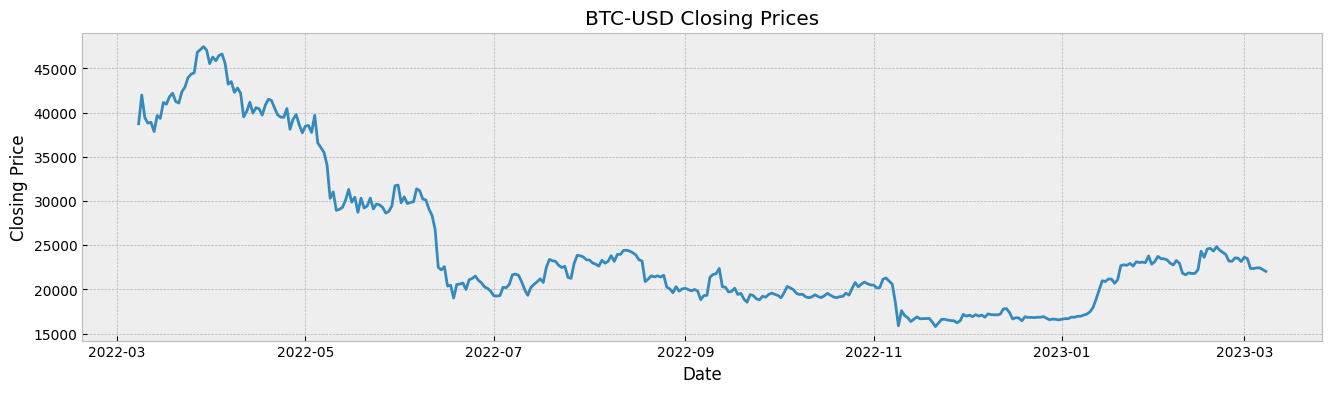

In [10]:
import matplotlib.pyplot as plt 

def displaySimplerStockChart(currency: str):
    plt.style.use("bmh")
    closeData  = getCloseCurrencyMarketElement(currency)
    dateData = getDateCurrencyMarketElement(currency)
    plt.figure(figsize=(16,4))
    plt.title(f"{currency} Closing Prices")
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.plot(dateData,closeData)

# displayStockChart("BTC-USD","5y")
displaySimplerStockChart("BTC-USD")

<h3>Database Test</h3>

In [70]:
def GeneralDatabaseTest():
        #Test if db exists
    print("--- Database General Test ---")
    if os.path.exists("./mydatabase.db") : 
        print("Test 1 passed : Database exist")
    else : 
        print("Test failled : No database named `mydatabase.db` created")
        return 0
    return 1

def CurrenciesMetadatGeneralTest():
    """Assert the structure of the CURRENCIES_METADATA is good"""
    print("\n--- CURRENCIES_METADATA General Test ---")
    #Test if CURRENCIES_METADATA structure is good
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    request ='''SELECT * FROM CURRENCIES_METADATA'''
    c.execute(request)
    elem = c.fetchone()
    #First test number of element
    if len(elem) == 6 : 
        print("Test 2 passed : Number of element in table good")
    else : 
        print("Test failed : The number of element in the CURRENCIES_METADATA table isn't correct")
        return 0
    #Then test element types
    types = (int , str , str , int , int , str)
    testResult = True
    for i in range(len(elem)):
        if type(elem[i]) != types[i]:
            testResult = False
            print(f'Test failed : the type of the {i} element doesn\'t correspond, it\'s a {type(elem[i])} but should be a {types[i]}')
            return 0
    if testResult: print("Test 3 passed : Element types good")
    return 1

def CurrenciesMetadatGetTest():
    """Assert the first element of the CURRENCIES_METADATA table correspond to the `BTC-USD` one"""
    print("\n--- CURRENCIES_METADATA GET Method Test ---")
    btcusd = (1 , "BTC-USD" , "CRYPTOCURRENCY" , -1 , 0 , "UTC")
    resget = getCurrencyMetadataElement(1)
    t = np.column_stack((resget , btcusd))
    for i , j in t:
        if not i == j and j == -1:
            print(f'Test failed : the element get by the method does not correspond to the BTC-USD one the values {i} should be {j}')
            return 0
    print("Test 4 passed : The Element Fetched Correspond")
    return 1

def TestCurrencyTable():
    """Assert all the CURRENCIES_METADATA table structure and method are functionnal"""
    return CurrenciesMetadatGeneralTest() and CurrenciesMetadatGetTest()

def TestDatabase():
    """Assert all the database is functionnal"""
    if not GeneralDatabaseTest(): 
        print("Tests have Failed")
        return 0
    if not TestCurrencyTable(): 
        print("Tests have Failed")
        return 0
    

TestDatabase()

--- Database General Test ---
Test 1 passed : Database exist

--- CURRENCIES_METADATA General Test ---
Test 2 passed : Number of element in table good
Test 3 passed : Element types good

--- CURRENCIES_METADATA GET Method Test ---
Test 4 passed : The Element Fetched Correspond


<h2>Neural Network</h2>

Imports

In [2]:
import os 
import pandas as pd
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn

<h3>Dataset</h3>

In [4]:
class CurrencyDataset(Dataset) :
    def __init__(self , currency : str) -> None:
        self.currencyValues = getAllCurrencyMarketElement(currency)

    def __len__(self):
        return len(self.currencyValues)
    
    def __getitem__(self, idx : int):
        return self.currencyValues[idx]
    


train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

NameError: name 'training_data' is not defined

In [6]:
import torch
from torch import nn
from torch.nn import functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self, nbHiddenLayer : int , listNeuralByLayer : list):
      super(NeuralNetwork, self).__init__()
      for i in range(nbHiddenLayer+1):
        vars()["prices"+str(i)] = nn.Linear(listNeuralByLayer[i], listNeuralByLayer[i+1])

my_nn = NeuralNetwork(2,[30 , 5 , 5 , 10])
print (my_nn)

Using cpu device
NeuralNetwork()
